# Notebook

1. Quais foram os principais motivos que fizeram o NPS cair nos meses de abril, maio e junho? Foram motivos diferentes ou há algum problema que é constante em todos os meses?
2. Avaliando todos os pontos de contato da jornada, você identifica alguma oportunidade que precisa ser direcionada para tratativa das equipes responsáveis?
3. Há alguma relação entre os indicadores operacionais e os dados coletados na base de dados da Pesquisa NPS?
4. Para enriquecer essa análise, você sente necessidade de explorar alguma informação adicional além dos dados trazidos nesse estudo? Se sim, quais indicadores você buscaria para cruzar com os dados que você já possui?




In [149]:
# Manipulação
import numpy as np
import pandas as pd

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

## Extração

Aba 1: NPS

In [56]:
df_nps_raw = pd.read_excel('Case_Análise Semestral - NPS - V2.xlsx', sheet_name='BASE_DADOS_NPS')
df_nps_raw.head(3)

,Id,Data_Voo,Minutos_Atraso,Tempo_Voo,AirportLegs,Equipamento_Tipo,Nota_Principal,Nota_CheckinWeb,Nota_CheckinMobile,Nota_Comissarios,...,O processo de check in web funcionou corretamente?,O processo de check in web foi simples?,O processo de check in pelo celular foi simples?,O processo de check in pelo celular funcionou corretamente?,O sistema de entretenimento apresentou algum problema durante o voo?,Qual foi o problema?,Foi oferecido fone a bordo?,O tempo de espera pela bagagem no destino foi satisfatório?,Você ficou satisfeito com as condições de sua bagagem na devolução?,Você ficou satisfeito com o atendimento em caso de dano/extravio?
0,1814257,2022-01-01 00:00:00,0.0,210,REC/GRU,A320,10,NaN,10.0,10.0,...,NaN,NaN,Sim,Sim,NaN,NaN,NaN,Não,Sim,NaN
1,1813841,2022-01-01 00:00:00,5.0,225,GYN/VCP/POA,Embraer-A320,8,NaN,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sim,Sim,NaN
2,1814905,2022-01-01 00:00:00,0.0,385,DOU/VCP/SSA,ATR-A320,10,10.0,NaN,10.0,...,Sim,Sim,NaN,NaN,NaN,NaN,NaN,Sim,Sim,Sim


In [222]:
# Ao longo do estudo foram encontradas inconsistência na base. Para evitar replicar análises anteriores, as inconsistências foram concentradas no início do notebook.
df_nps = df_nps_raw.copy(deep=True)

df_nps['inconsistencia'] = np.select(
    [
        df_nps['Data_Voo'].astype(str).str.contains('29/02'),
        df_nps_raw['Tempo_Voo'] <= 0
    ],
    [
        'voo em 29/02/2022',
        'duracao de voo <= 0'
    ], 'ok'
)

df_nps['inconsistencia'].value_counts()

ok                     2870
voo em 29/02/2022        18
duracao de voo <= 0       2
Name: inconsistencia, dtype: int64

In [223]:
# Preprocessamento básico.
df_nps = df_nps.loc[df_nps['inconsistencia'] == 'ok'].reset_index(drop=True)
df_nps['Data_Voo'] = pd.to_datetime(df_nps['Data_Voo'], format='%Y-%m-%d %H:%M:%S')

df_nps.head(3)

,Id,Data_Voo,Minutos_Atraso,Tempo_Voo,AirportLegs,Equipamento_Tipo,Nota_Principal,Nota_CheckinWeb,Nota_CheckinMobile,Nota_Comissarios,...,O processo de check in web foi simples?,O processo de check in pelo celular foi simples?,O processo de check in pelo celular funcionou corretamente?,O sistema de entretenimento apresentou algum problema durante o voo?,Qual foi o problema?,Foi oferecido fone a bordo?,O tempo de espera pela bagagem no destino foi satisfatório?,Você ficou satisfeito com as condições de sua bagagem na devolução?,Você ficou satisfeito com o atendimento em caso de dano/extravio?,inconsistencia
0,1814257,2022-01-01,0.0,210,REC/GRU,A320,10,NaN,10.0,10.0,...,NaN,Sim,Sim,NaN,NaN,NaN,Não,Sim,NaN,ok
1,1813841,2022-01-01,5.0,225,GYN/VCP/POA,Embraer-A320,8,NaN,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Sim,Sim,NaN,ok
2,1814905,2022-01-01,0.0,385,DOU/VCP/SSA,ATR-A320,10,10.0,NaN,10.0,...,Sim,NaN,NaN,NaN,NaN,NaN,Sim,Sim,Sim,ok


Aba 2: Outros indicadores

In [224]:
df_kpi_raw = pd.read_excel('Case_Análise Semestral - NPS - V2.xlsx', sheet_name='Outros Indicadores')
df_kpi_raw

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,Indicador,jan/22,fev/22,mar/22,abr/22,mai/22,jun/22
1,NaN,Dark Flight ⁽¹⁾,2.34,2.17,1.69,2.24,1.88,3.59
2,NaN,MBR ⁽²⁾,1.467711,1.484345,1.426646,1.555159,1.66,2.21882
3,NaN,Pontualidade D14 ⁽³⁾,0.911643,0.909311,0.909455,0.882785,0.865582,0.810266
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,⁽¹⁾ Dark Flights = Índice que determina o % de...,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,⁽²⁾ MBR = índice que determina a quantidade de...,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,⁽³⁾ Pontualidade D14 = índice que determina o ...,NaN,NaN,NaN,NaN,NaN,NaN


In [225]:
# Processamento básico.
df_kpi = df_kpi_raw.T
df_kpi = df_kpi.iloc[2:, :4].reset_index(drop=True)
df_kpi.columns = ['data', 'dark_flight', 'mbr', 'pontualidade']
df_kpi[['dark_flight', 'mbr', 'pontualidade']]= df_kpi[['dark_flight', 'mbr', 'pontualidade']].astype('float')

df_kpi

,data,dark_flight,mbr,pontualidade
0,jan/22,2.34,1.467711,0.911643
1,fev/22,2.17,1.484345,0.909311
2,mar/22,1.69,1.426646,0.909455
3,abr/22,2.24,1.555159,0.882785
4,mai/22,1.88,1.660000,0.865582
5,jun/22,3.59,2.218820,0.810266


## Validações

In [226]:
# Temos realmente um ID por vôo?
print(f"Qtd. de vôos: {df_nps.shape[0]}")
print(f"Qtd. de ids únicos: {df_nps['Id'].nunique()}")

Qtd. de vôos: 2870
Qtd. de ids únicos: 2870


In [227]:
# Realmente temos vôos apenas entre jan/22 a jun22?
print(f"Data do primeiro registro: {df_nps['Data_Voo'].min()}")
print(f"Data do último registro: {df_nps['Data_Voo'].max()}")

Data do primeiro registro: 2022-01-01 00:00:00
Data do último registro: 2022-06-30 00:00:00


## Exploração

     count    mean    std    min    25%    50%    75%    max
mes    6.0  478.33  61.18  405.0  423.5  491.5  528.0  541.0


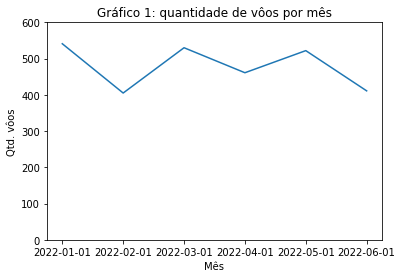

In [228]:
# Quantos registros por mês?
df_nps['mes'] = df_nps['Data_Voo'].dt.strftime('%Y-%m-01')
df_plot = df_nps['mes'].value_counts().reset_index().sort_values('index', ascending=True)
print(df_plot.describe().T.round(2))

fig = sns.lineplot(data=df_plot, x='index', y='mes')
fig.set(title='Gráfico 1: quantidade de vôos por mês', ylim=(0, 600), ylabel='Qtd. vôos', xlabel='Mês')
plt.show()

Datas

Durante o primeiro semestre registrou-se em média 478 vôos por mês. A distribuição dos vôos mostrou-se relativamente comportada, porém é curiosa a queda de vôos em fev/22. A princípio, considerando os feriados de Carnaval, é de se imaginar que há maior quantidade de viagens, contudo, os dados mostram o contrário: queda de aproximadamente 20% em relação a janeiro. Por outro lado, é importante em 2022 fevereiro foi um mês mais curto, com apenas 28 dias.

In [315]:
# Quais os comportamentos entre (1) dia de semana e (2) fim de semana/feriados?
feriados_br = [
    '2022-01-01',
    '2022-02-28',
    '2022-03-01',
    '2022-04-15',
    '2022-04-21',
    '2022-05-01',
    '2022-06-16',
    ]

df_nps['dummy_fds_feriado'] = np.select(
    [
        df_nps['Data_Voo'].astype(str).isin(feriados_br),
        df_nps['Data_Voo'].dt.dayofweek.isin([5, 6])
    ],
    [
        1,
        1
    ], 0
) 

print(df_nps['dummy_fds_feriado'].value_counts())
# obs: é uma pena que a amostra não contém horas, pois isso facilitaria diferenciar vôos comerciais e de lazer.
# Ex: vôos de sexta a noite, que podem significar o início de uma viagem de lazer, ainda serão considerados como vôos comerciais a trabalho.

0    1962
1     908
Name: dummy_fds_feriado, dtype: int64


Fim de semana/feriado

Praticamente 1/3 da amostra é de vôos em fim de semana/feriado. Essa pode ser uma variável promissora, dada que em viagens de lazer a satisfação do cliente pode estar viesada positivamente.

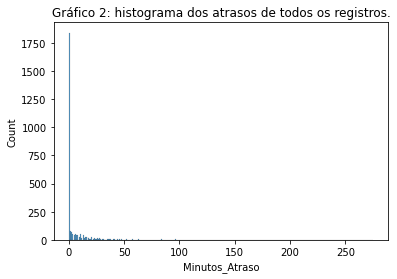

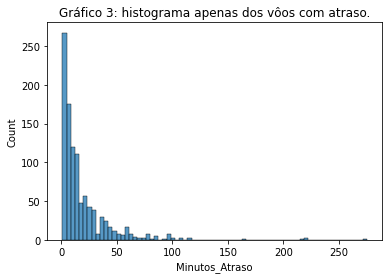

,count,mean,std,min,25%,50%,75%,max
Minutos_Atraso,1030.0,18.578641,24.349678,1.0,4.0,11.0,23.0,275.0


In [229]:
# Qual o comportamento geral dos atrasos?
fig1 = sns.histplot(df_nps['Minutos_Atraso'])
fig1.set(title='Gráfico 2: histograma dos atrasos de todos os registros.')
plt.show()

fig2 = sns.histplot(df_nps.loc[df_nps['Minutos_Atraso'] > 0, 'Minutos_Atraso'])
fig2.set(title='Gráfico 3: histograma apenas dos vôos com atraso.')
plt.show()

df_nps.loc[df_nps['Minutos_Atraso'] > 0][['Minutos_Atraso']].describe().T

Atrasos

De todos os vôos, 1030 (aproximadamente 37%) registraram atrasos. Enquanto a metade dos atrasos foram de até 11 minutos, também houveram atrasos de 275 minutos. Essa variável é promissora na análise de NPS, dada a alta frequência de atrasos.

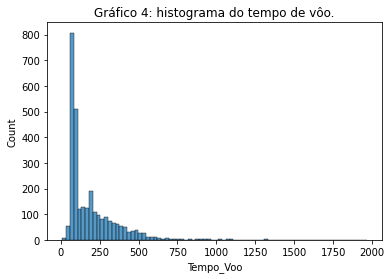

,count,mean,std,min,25%,50%,75%,max
Tempo_Voo,2870.0,192.906272,174.611831,10.0,80.0,115.0,255.0,1965.0


In [235]:
# Qual comportamento do tempo de vôo?
fig1 = sns.histplot(df_nps['Tempo_Voo'])
fig1.set(title='Gráfico 4: histograma do tempo de vôo.')
plt.show()

df_nps['Tempo_Voo'].describe().to_frame().T

In [249]:
# Como pode existir um tempo de vôo negativo?
df_nps_raw.loc[df_nps_raw['Tempo_Voo'] <= 0]

# obs: verificação na base original (df_nps_raw), dado que na base processada esse caso já foi removido.

,Id,Data_Voo,Minutos_Atraso,Tempo_Voo,AirportLegs,Equipamento_Tipo,Nota_Principal,Nota_CheckinWeb,Nota_CheckinMobile,Nota_Comissarios,...,O processo de check in web funcionou corretamente?,O processo de check in web foi simples?,O processo de check in pelo celular foi simples?,O processo de check in pelo celular funcionou corretamente?,O sistema de entretenimento apresentou algum problema durante o voo?,Qual foi o problema?,Foi oferecido fone a bordo?,O tempo de espera pela bagagem no destino foi satisfatório?,Você ficou satisfeito com as condições de sua bagagem na devolução?,Você ficou satisfeito com o atendimento em caso de dano/extravio?
1745,1887425,2022-04-17 00:00:00,0.0,-790,JDO/PNZ/VCP/CWB/IGU,Embraer,10,NaN,NaN,10.0,...,NaN,NaN,NaN,NaN,Não,NaN,Não,Sim,Não,Não
2627,1905642,2022-06-12 00:00:00,NaN,0,FOR/SLZ,A320,10,10.0,NaN,10.0,...,Sim,Sim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [250]:
# Qual vôo tem tempo de 10 minutos?
df_nps.loc[df_nps['Tempo_Voo'] == df_nps['Tempo_Voo'].min()]

,Id,Data_Voo,Minutos_Atraso,Tempo_Voo,AirportLegs,Equipamento_Tipo,Nota_Principal,Nota_CheckinWeb,Nota_CheckinMobile,Nota_Comissarios,...,O processo de check in pelo celular foi simples?,O processo de check in pelo celular funcionou corretamente?,O sistema de entretenimento apresentou algum problema durante o voo?,Qual foi o problema?,Foi oferecido fone a bordo?,O tempo de espera pela bagagem no destino foi satisfatório?,Você ficou satisfeito com as condições de sua bagagem na devolução?,Você ficou satisfeito com o atendimento em caso de dano/extravio?,inconsistencia,mes
1312,1853584,2022-03-22,0.0,10,FEN/REC,Embraer,10,NaN,10.0,10.0,...,Sim,Sim,Não,NaN,Sim,Sim,Sim,NaN,ok,2022-03-01


Duração

A duração dos vôos é heterogênea, apresentando durações de 10 a 1965 minutos. Essa amostra, entretanto, parece conter problemas: a menor duração válida é de 10 minutos, partindo de Fernando de Noronha para Recife. Uma breve pesquisa na internet indica que esse trecho é coberto em aproximadamente 95 minuto pela própria Azul, que é muito mais crível que os 10 minutos presentes na amostra. Apesar de promissora, esse dado precisa ser levado com parcimônia.

In [333]:
# Qual é o comportamento dos Aeroportos?
df_nps['list_airport'] = df_nps['AirportLegs'].str.split('/')
df_nps['list_airport'].value_counts()[:4]

[SSA, VCP]    29
[VCP, SDU]    29
[CNF, SDU]    27
[CWB, IGU]    25
Name: list_airport, dtype: int64

In [287]:
# Quais são os aerportos mais visitados pela Azul?
dict_airport = {}
for i in df_nps['list_airport']:
    for j in i:
        if j not in dict_airport.keys():
            dict_airport[j] = 1
        else:
            dict_airport[j] += 1

ranking_airports = sorted(dict_airport.items(), key=lambda x:x[1], reverse=True)
print(f"Top 5: {ranking_airports[:5]}")
print(f"Bottom 5: {ranking_airports[-5:]}")

Top 5: [('VCP', 1045), ('CNF', 725), ('REC', 471), ('GRU', 373), ('POA', 372)]
Bottom 5: [('FEC', 2), ('LAJ', 1), ('CFB', 1), ('VAL', 1), ('PHB', 1)]


Aeroportos

Os top 5 aeroportos mais visitados são:
- VRP (ViraCopos, SP): 1045
- CNF (Confins, MG): 725
- REC (Recife/Guararapes, RE): 471
- GRU (Guarulhos, SP): 373
- POA (Porto Alegre, RS): 372

Já os top 5 aeroportos menos visitados são:
- FEC (Feira de Santana, BA): 1
- LAJ (Lages, SC): 1
- CFB (Cabo Frio, RJ): 1
- VAL (Val de Cans, PA): 1
- PHB (Parnaíba, PI): 1

Faz sentido que a presença da Azul seja maior em Campinas, dada a localização de sua sede. Além disso, é possível que a alta frequência de vôos esteja correlacionada com o NPS, dado que se a Azul faz muitos vôos para determinado aeroporto, faz sentido alocar maior parcela de recursos, melhorando o serviço em geral. 

In [282]:
# Quais são as principais aeronaves usadas?
df_nps['Equipamento_Tipo'].value_counts()

Embraer         1635
A320             404
ATR              250
Embraer-ATR      242
Embraer-A320     207
ATR-A320          94
MISTO             18
A330              11
Embraer-A330       6
ATR-A330           3
Name: Equipamento_Tipo, dtype: int64

Equipamentos

A grande maioria dos vôos conta com equipamentos da Embraer (principal), ATR e Airbus. Dos 1635 registros `Embraer`, entretanto, não é possível extrair mais detalhes da aeronave, o que pode camuflar comportamentos que ocorrem exclusivamente com determinados equipamentos.

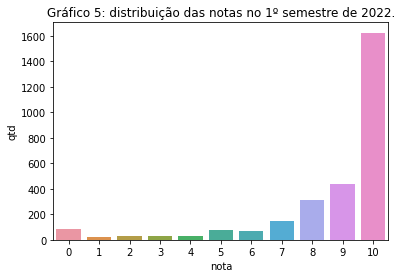

,count,mean,std,min,25%,50%,75%,max
Nota_Principal,2870.0,8.642857,2.36072,0.0,8.0,10.0,10.0,10.0


In [335]:
# NPS em geral.
df_plot = df_nps['Nota_Principal'].value_counts().reset_index().sort_values('index', ascending=False)
df_plot.columns = ['nota', 'qtd']

fig = sns.barplot(data=df_plot, x='nota', y='qtd')
fig.set(title='Gráfico 5: distribuição das notas no 1º semestre de 2022.')
plt.show()

df_nps['Nota_Principal'].describe().to_frame().T

In [340]:
# Temos nota principal em todas os vôos?
print(f"Quantidade de notas principais: {df_nps.loc[df_nps['Nota_Principal'].notnull()].shape[0]}")

Quantidade de notas principais: 2870


In [422]:
def calcular_nps(df, coluna):
    # Definição de perfil de votos por vôo.
    df['perfil_cliente'] = np.select(
        [
            df[coluna] <= 6,
            df[coluna].between(7, 8),
            df[coluna] >= 9,
        ],
        [
            'detrator',
            'neutro',
            'promotor'
        ], '?'
    )

    # Cálculo de NPS por mês.
    df_mes = pd.pivot_table(data=df, values='Id', index='mes', columns='perfil_cliente', aggfunc='count', margins=True, margins_name='total').reset_index(drop=False).iloc[:-1, :]
    df_mes['nps'] = (df_mes['promotor'] - df_mes['detrator'])/df_mes['total']

    return df_mes

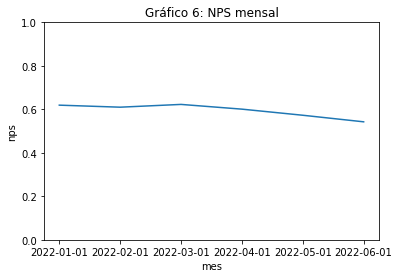

In [428]:
# Tabela contendo o nps calculado manualmente.
df_nps_mes = calcular_nps(df_nps, 'Nota_Principal')

fig = sns.lineplot(data=df_nps_mes, x='mes', y='nps')
fig.set(title='Gráfico 6: NPS mensal', ylim=(0,1))
plt.show()

NPS mensal

As notas de NPS não batem na vírgula com os valores apresentados no Excel pois os casos com inconsistências foram desconsideradas. Apesar disso, o comportamento temporal de crescimentos e quedas se manteve.

![nps original](nps.PNG)

In [366]:
# Será que alguém deu nota ambos para o Checkin Web e Mobile?
print(f"Quantas pessoas deram nota ambos para o Checkin Web e Mobile: {df_nps.loc[(df_nps['Nota_CheckinWeb'].notnull()) & (df_nps['Nota_CheckinMobile'].notnull())].shape[0]}")

# obs: é possível supor que a pessoa se enganou e acabou preenchendo duas vezes. Nesses casos, consdervadoramente, será considerada a menor nota.

Quantas pessoas deram nota ambos para o Checkin Web e Mobile: 2


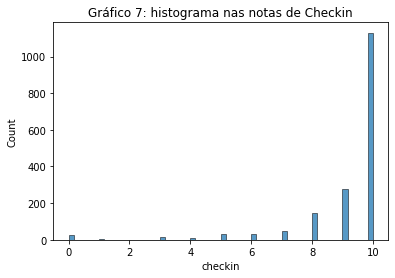

,NaN,10.0,9.0,8.0,7.0,5.0,6.0,0.0,3.0,4.0,1.0,2.0
checkin,1148,1130,276,144,48,33,32,26,14,11,7,1


In [429]:
# Unificando as notas de Checkin Web e Mobile
df_nps['checkin'] = np.where(df_nps['Nota_CheckinMobile'].isnull(), df_nps['Nota_CheckinWeb'], df_nps['Nota_CheckinMobile'])

# Aplicando a regra da menornota.
for index, row in df_nps.iterrows():
    if (pd.isnull(row['Nota_CheckinWeb'])) & (pd.isnull(row['Nota_CheckinMobile'])):
        valor = np.min([row['Nota_CheckinWeb'], row['Nota_CheckinMobile']])
        df_nps.at[index, 'checkin'] = valor

fig = sns.histplot(df_nps['checkin'])
fig.set(title='Gráfico 7: histograma nas notas de Checkin')
plt.show()

df_nps['checkin'].value_counts(dropna=False).to_frame().T

In [410]:
# Quem deu nota do Checkn Web também respondeu sobre simplicidade e funcionamento?
print('Quem respondeu nota, mas não as outras perguntas')
display(df_nps.loc[
    (df_nps['Nota_CheckinWeb'].notnull()) &\
    (df_nps['O processo de check in web funcionou corretamente?'].isnull()) &\
    (df_nps['O processo de check in web foi simples?'].isnull())
][['Nota_CheckinWeb', 'O processo de check in web funcionou corretamente?', 'O processo de check in web foi simples?']])

print('Quem não respondeu nota, mas sim as outras perguntas')
display(df_nps.loc[
    (df_nps['Nota_CheckinWeb'].isnull()) &\
    (df_nps['O processo de check in web funcionou corretamente?'].notnull()) &\
    (df_nps['O processo de check in web foi simples?'].notnull())
][['Nota_CheckinWeb', 'O processo de check in web funcionou corretamente?', 'O processo de check in web foi simples?']]
)

Quem respondeu nota, mas não as outras perguntas


,Nota_CheckinWeb,O processo de check in web funcionou corretamente?,O processo de check in web foi simples?
105,9.0,NaN,NaN
981,10.0,NaN,NaN
1263,9.0,NaN,NaN
2469,10.0,NaN,NaN


Quem não respondeu nota, mas sim as outras perguntas


,Nota_CheckinWeb,O processo de check in web funcionou corretamente?,O processo de check in web foi simples?


In [414]:
# Quem deu nota do Checkn Mobile também respondeu sobre simplicidade e funcionamento?
print('Quem respondeu nota, mas não as outras perguntas')
display(df_nps.loc[
    (df_nps['Nota_CheckinMobile'].notnull()) &\
    (df_nps['O processo de check in pelo celular funcionou corretamente?'].isnull()) &\
    (df_nps['O processo de check in pelo celular foi simples?'].isnull())
][['Nota_CheckinMobile', 'O processo de check in pelo celular funcionou corretamente?', 'O processo de check in pelo celular foi simples?']])

print('Quem não respondeu nota, mas sim as outras perguntas')
display(df_nps.loc[
    (df_nps['Nota_CheckinMobile'].isnull()) &\
    (df_nps['O processo de check in pelo celular funcionou corretamente?'].notnull()) &\
    (df_nps['O processo de check in pelo celular foi simples?'].notnull())
][['Nota_CheckinMobile', 'O processo de check in pelo celular funcionou corretamente?', 'O processo de check in pelo celular foi simples?']]
)

Quem respondeu nota, mas não as outras perguntas


,Nota_CheckinMobile,O processo de check in pelo celular funcionou corretamente?,O processo de check in pelo celular foi simples?
842,9.0,NaN,NaN
843,10.0,NaN,NaN
889,10.0,NaN,NaN
1315,0.0,NaN,NaN
2496,9.0,NaN,NaN
2810,6.0,NaN,NaN


Quem não respondeu nota, mas sim as outras perguntas


,Nota_CheckinMobile,O processo de check in pelo celular funcionou corretamente?,O processo de check in pelo celular foi simples?


Checkin

Temos praticamente 55% de respondentes sobre o Checkin, sendo que praticamente todos também responderam as perguntas sobre o funcionamento e a simplicidade de uso do Checkin. 

In [421]:
# Como estão as notas de forma geral?
df_nps[['Nota_Principal', 'checkin', 'Nota_Comissarios', 'Nota_Entretenimento', 'Nota_Bagagem']].describe().round(2)

,Nota_Principal,checkin,Nota_Comissarios,Nota_Entretenimento,Nota_Bagagem
count,2870.00,1722.00,2738.00,1377.00,1260.00
mean,8.64,9.13,9.32,8.76,8.17
std,2.36,1.81,1.43,1.92,2.51
min,0.00,0.00,0.00,0.00,0.00
25%,8.00,9.00,9.00,8.00,8.00
50%,10.00,10.00,10.00,10.00,9.00
75%,10.00,10.00,10.00,10.00,10.00
max,10.00,10.00,10.00,10.00,10.00


In [446]:
# Unificar os NPS de cada categoria
df_checkin = calcular_nps(df_nps, 'checkin')
df_comissar = calcular_nps(df_nps, 'Nota_Comissarios')
df_entrete = calcular_nps(df_nps, 'Nota_Entretenimento')
df_bag = calcular_nps(df_nps, 'Nota_Bagagem')

df_nps_merge = df_nps_mes
df_nps_merge = pd.merge(df_nps_merge[['mes', 'nps']], df_checkin[['mes', 'nps']].rename(columns={'nps':'checkin'}), on='mes', how='left')
df_nps_merge = pd.merge(df_nps_merge[['mes', 'nps', 'checkin']], df_comissar[['mes', 'nps']].rename(columns={'nps':'comissario'}), on='mes', how='left')
df_nps_merge = pd.merge(df_nps_merge[['mes', 'nps', 'checkin', 'comissario']], df_entrete[['mes', 'nps']].rename(columns={'nps':'entretenimento'}), on='mes', how='left')
df_nps_merge = pd.merge(df_nps_merge[['mes', 'nps', 'checkin', 'comissario', 'entretenimento']], df_bag[['mes', 'nps']].rename(columns={'nps':'bagagem'}), on='mes', how='left')

df_nps_merge

perfil_cliente,mes,nps,checkin,comissario,entretenimento,bagagem
0,2022-01-01,0.619224,0.460259,0.813309,0.264325,0.194085
1,2022-02-01,0.609877,0.429630,0.770370,0.301235,0.150617
2,2022-03-01,0.622642,0.466038,0.762264,0.322642,0.175472
3,2022-04-01,0.600868,0.462039,0.772234,0.279826,0.214751
4,2022-05-01,0.572797,0.434866,0.749042,0.272031,0.180077
5,2022-06-01,0.542579,0.418491,0.739659,0.284672,0.209246


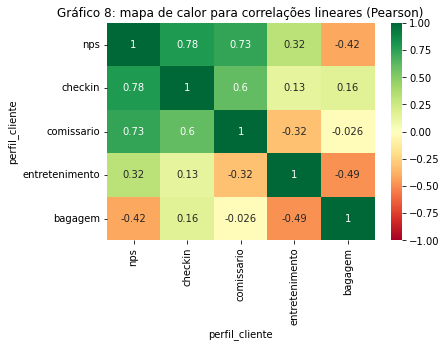

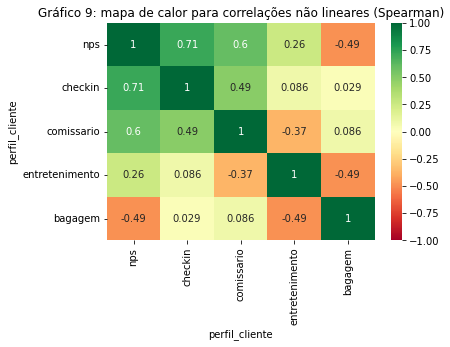

In [458]:
fig = sns.heatmap(df_nps_merge.corr(method='pearson'), vmin=-1, vmax=1, cmap='RdYlGn', annot=True)
fig.set(title='Gráfico 8: mapa de calor para correlações lineares (Pearson)')
plt.show()

fig = sns.heatmap(df_nps_merge.corr(method='spearman'), vmin=-1, vmax=1, cmap='RdYlGn', annot=True)
fig.set(title='Gráfico 9: mapa de calor para correlações não lineares (Spearman)')
plt.show()

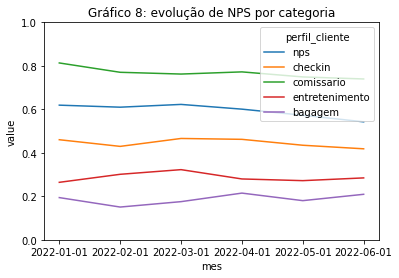

In [447]:
# Plot do NPS de todas as categorias.
fig = sns.lineplot(data=pd.melt(df_nps_merge, id_vars='mes', value_vars=['nps', 'checkin', 'comissario', 'entretenimento', 'bagagem']), x='mes', y='value', hue='perfil_cliente')
fig.set(title='Gráfico 8: evolução de NPS por categoria', ylim=(0,1))
plt.show()

Categorias de NPS

Existem 5 categorias de notas na amostra: nota principal, checkin, comissários, entretenimento e bagagem. Considerando a nota principal como o foco do estudo, o checkin e comissario também apresentam queda no 2º trimestre de 2022, contudo, entretenimento e bagagem apresentam uma melhora. Além disso, as notas de comissário são maiores que a nota principal.

Considerando a correlação entre variáveis e a amostra disponível, a ordem de prioridade das validações deve ser:
- Comissários
- Checkin
- Bagagem
- Entretenimento

In [ ]:
# Cruzando NPS com outras variáveis.

## Análise de hipóteses

Comissários:
- 

## Conclusão

Aprendizados:

- Dia 29/02/2022: existem 18 vôos erroneamente registrados em 29/02/2022, os quais serão omitidos da amostra.
- Atrasos: os atrasos no vôos podem ser decorrentes de fatores internos (ex: atraso no fluxo operacional dos técnicos da Azul) mas também externos (ex: atraso na pista causadas por outras aeronaves). Seria valioso contar com alguma base que pudesse capturar esse efeito.
- Nota de Comissários: apresenta alta correlação com 